# Chapter 7
## Unsupervised Learning

import required Python packages.

In [1]:
import math
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import multivariate_normal

import prince

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import from_levels_and_colors
import seaborn as sns

%matplotlib inline



In [2]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [3]:
SP500_DATA_CSV = DATA / 'sp500_data.csv.gz'
SP500_SECTORS_CSV = DATA / 'sp500_sectors.csv'
LOAN_DATA_CSV = DATA / 'loan_data.csv.gz'
HOUSE_TASK_CSV = DATA / 'housetasks.csv'

## Principal Components Analysis
### A simple example

You can compute principal components in R using the princomp function. The following
performs a PCA on the stock price returns for Chevron (CVX) and Exxon‐
Mobil (XOM):

In [4]:
sp500_px = pd.read_csv(SP500_DATA_CSV, index_col=0)
# sp500_px.head(10)
sp500_px.info(10)


<class 'pandas.core.frame.DataFrame'>
Index: 5647 entries, 1993-01-29 to 2015-07-01
Data columns (total 517 columns):
 #    Column  Dtype  
---   ------  -----  
 0    ADS     float64
 1    CA      float64
 2    MSFT    float64
 3    RHT     float64
 4    CTSH    float64
 5    CSC     float64
 6    EMC     float64
 7    IBM     float64
 8    XRX     float64
 9    ALTR    float64
 10   ADI     float64
 11   AVGO    float64
 12   BRCM    float64
 13   FSLR    float64
 14   INTC    float64
 15   LLTC    float64
 16   MCHP    float64
 17   MU      float64
 18   NVDA    float64
 19   QRVO    float64
 20   QCOM    float64
 21   SWKS    float64
 22   TXN     float64
 23   XLNX    float64
 24   AAPL    float64
 25   HPQ     float64
 26   EA      float64
 27   SNDK    float64
 28   STX     float64
 29   WDC     float64
 30   TEL     float64
 31   HRS     float64
 32   MSI     float64
 33   ACN     float64
 34   AMAT    float64
 35   KLAC    float64
 36   LRCX    float64
 37   ADBE    float64
 3

In [5]:
oil_px = sp500_px[['XOM', 'CVX']]
print(oil_px.head())

                 XOM       CVX
1993-01-29 -0.016991  0.072921
1993-02-01  0.016991  0.102089
1993-02-02  0.084954  0.029168
1993-02-03  0.067964  0.058337
1993-02-04  0.034378  0.044272


In [6]:
# In Python, we can use the scikit-learn implementation sklearn.decomposition.PCA
pcs = PCA(n_components=2) #descomposition
pcs.fit(oil_px)
loadings = pd.DataFrame(pcs.components_, columns=oil_px.columns)
print(loadings)

        XOM       CVX
0 -0.664711 -0.747101
1  0.747101 -0.664711


>The weights for CVX and XOM for the first principal component are –0.747 and
–0.665, and for the second principal component they are 0.665 and –0.747. How to
interpret this? The first principal component is essentially an average of CVX and
XOM, reflecting the correlation between the two energy companies. The second principal
component measures when the stock prices of CVX and XOM diverge.

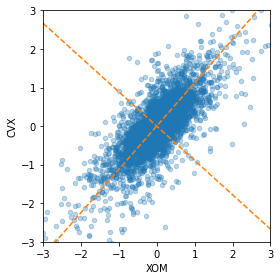

Figure 7-1. The principal components for the stock returns for Chevron (CVX) and ExxonMobil (XOM)


In [7]:
def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)

ax = oil_px.plot.scatter(x='XOM', y='CVX', alpha=0.3, figsize=(4, 4))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.plot(*abline(loadings.loc[0, 'CVX'] / loadings.loc[0, 'XOM'], 0, ax),
       '--', color='C1')
ax.plot(*abline(loadings.loc[1, 'CVX'] / loadings.loc[1, 'XOM'], 0, ax),
       '--', color='C1')

plt.tight_layout()
plt.show()
print("Figure 7-1. The principal components for the stock returns for Chevron (CVX) and ExxonMobil (XOM)")

## Interpreting principal components

The nature of the principal components often reveals information about the structure
of the data. There are a couple of standard visualization displays to help you glean
insight about the principal components. One such method is a screeplot to visualize
the relative importance of principal components (the name derives from the resemblance
of the plot to a scree slope; here, the y-axis is the eigenvalue).


The information to create a loading plot from the scikit-learn result is available in
explained_variance_. Here, we convert it into a pandas data frame and use it to
make a bar chart:

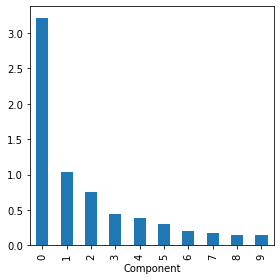

Figure 7-2. A screeplot for a PCA of top stocks from the S&P 500


In [8]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP',
        'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]

sp_pca = PCA()
sp_pca.fit(top_sp)

explained_variance = pd.DataFrame(sp_pca.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')

plt.tight_layout()
plt.show()
print("Figure 7-2. A screeplot for a PCA of top stocks from the S&P 500")

In [9]:
loadings = pd.DataFrame(sp_pca.components_[0:5, :],
                           columns=top_sp.columns)
print(loadings)

       AAPL       AXP       COP      COST      CSCO       CVX        HD  \
0 -0.300825 -0.246332 -0.261529 -0.273634 -0.064059 -0.444490 -0.207983   
1 -0.505116 -0.139426  0.174212 -0.416307 -0.031939  0.289373 -0.278002   
2 -0.786730  0.135458 -0.002367  0.465862 -0.007524  0.082374  0.166320   
3 -0.120586  0.061814 -0.206026  0.092596  0.003904 -0.577665  0.162814   
4  0.111576 -0.596666 -0.005813  0.555529 -0.039860  0.109016 -0.185488   

       INTC       JPM      MSFT       SLB       TGT       USB       WFC  \
0 -0.076956 -0.196397 -0.105012 -0.481786 -0.148833 -0.116421 -0.145684   
1 -0.033898 -0.040723 -0.053954  0.472494 -0.228123 -0.054796 -0.047427   
2 -0.003518  0.062261  0.016248 -0.194822  0.160833  0.048976  0.041932   
3 -0.001605  0.057687 -0.012558  0.680914  0.109895  0.016752  0.018614   
4 -0.072047 -0.385160 -0.077135  0.181332 -0.055557 -0.155440 -0.216425   

        WMT       XOM  
0 -0.122304 -0.317952  
1 -0.222889  0.154192  
2  0.175806  0.090167  
3 

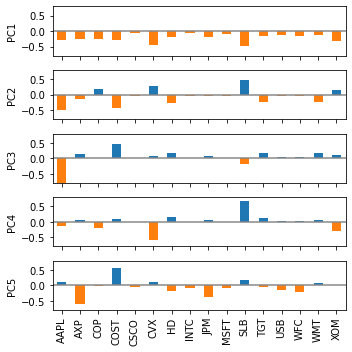

Figure 7-3. The loadings for the top five principal components of stock price returns


In [10]:
maxPC = 1.01 * np.max(np.max(np.abs(loadings.loc[0:5, :])))

f, axes = plt.subplots(5, 1, figsize=(5, 5), sharex=True)

for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i, :]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-maxPC, maxPC)
    
plt.tight_layout()
plt.show()
print("Figure 7-3. The loadings for the top five principal components of stock price returns")

The loadings for the top five components are shown in Figure 7-3. The loadings for
the first principal component have the same sign: this is typical for data in which all
the columns share a common factor (in this case, the overall stock market trend). The
second component captures the price changes of energy stocks as compared to the
other stocks. The third component is primarily a contrast in the movements of Apple
and CostCo. The fourth component contrasts the movements of Schlumberger (SLB)
to the other energy stocks. Finally, the fifth component is mostly dominated by financial
companies.

### Correspondence analysis

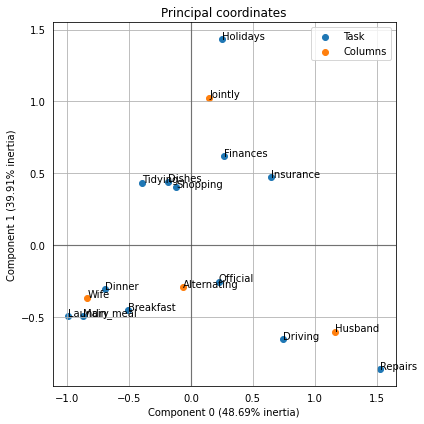

Figure 7-4. Graphical representation of a correspondence analysis of house task data


In [11]:
# In Python, we can use the prince package, which implements correspondence analysis using the scikit-learn API
housetasks = pd.read_csv(HOUSE_TASK_CSV, index_col=0)

ca = prince.CA(n_components=2)
ca = ca.fit(housetasks)

ca.plot_coordinates(housetasks, figsize=(6, 6))
plt.tight_layout()
plt.show()
print("Figure 7-4. Graphical representation of a correspondence analysis of house task data")

## K-Means Clustering

### A Simple Example

Kmeans
clustering can be used to separate the data into the best groupings. Note that
daily stock returns are reported in a fashion that is, in effect, standardized, so we do
not need to normalize the data. In R, K-means clustering can be performed using the
kmeans function. For example, the following finds four clusters based on two variables—
the daily stock returns for ExxonMobil (XOM) and Chevron (CVX):

In [12]:
# We use the sklearn.cluster.KMeans method from scikit-learn in Python
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
kmeans = KMeans(n_clusters=4).fit(df)
df['cluster'] = kmeans.labels_
print(df.head())

                 XOM       CVX  cluster
2011-01-03  0.736805  0.240681        0
2011-01-04  0.168668 -0.584516        2
2011-01-05  0.026631  0.446985        0
2011-01-06  0.248558 -0.919751        2
2011-01-07  0.337329  0.180511        0


In [13]:
# In scikit-learn, the cluster centers are available in the cluster_centers_ field
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['XOM', 'CVX'])
print(centers)

        XOM       CVX
0  0.242519  0.336479
1 -1.143980 -1.750297
2 -0.328486 -0.566914
3  0.960948  1.376572


Clusters 1 and 3 represent “down” markets, while clusters 2 and 4 represent “up
markets.”


As the K-means algorithm uses randomized starting points, the results may differ
between subsequent runs and different implementations of the method. In general,
you should check that the fluctuations aren’t too large.
In this example, with just two variables, it is straightforward to visualize the clusters
and their means:

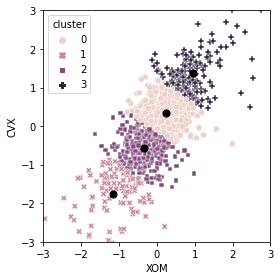

Figure 7-5. The clusters of K-means applied to daily stock returns for ExxonMobil and
Chevron (the cluster centers are highlighted with black symbols)


In [14]:
fig, ax = plt.subplots(figsize=(4, 4))
ax = sns.scatterplot(x='XOM', y='CVX', hue='cluster', style='cluster',
                    ax=ax, data=df)

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
centers.plot.scatter(x='XOM', y='CVX', ax=ax, s=50, color='black')

plt.tight_layout()
plt.show()
print("""Figure 7-5. The clusters of K-means applied to daily stock returns for ExxonMobil and
Chevron (the cluster centers are highlighted with black symbols)""")

### K-Means Algorithm
For example, the following code runs K-means to find 5 clusters
using 10 different starting cluster means:

The _scikit-Learn_ algorithm is repeated 10 times by default (`n_init`), `max_iter` is used to control the number of iterations.

In [15]:

syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP',
              'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])

top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]
kmeans = KMeans(n_clusters=5).fit(top_sp)

### Interpreting the Clusters

An important part of cluster analysis can involve the interpretation of the clusters.
The two most important outputs from kmeans are the sizes of the clusters and the
cluster means.


In Python, we can use the collections.Counter class from the standard library to
get this information. Due to differences in the implementation and the inherent randomness
of the algorithm, results will vary:

In [16]:
from collections import Counter
print(Counter(kmeans.labels_))

Counter({0: 302, 1: 293, 3: 248, 2: 183, 4: 105})


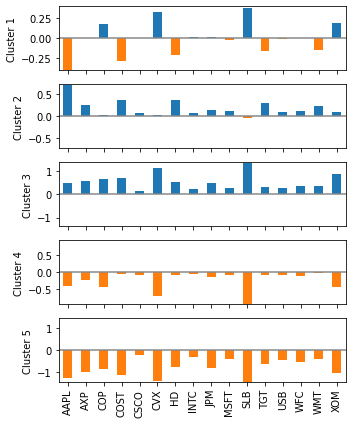

Figure 7-6. The means of the variables in each cluster (“cluster means”)


In [17]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=syms)

f, axes = plt.subplots(5, 1, figsize=(5, 6), sharex=True)
for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.01 * np.max(np.max(np.abs(center)))
    colors = ['C0' if l > 0 else 'C1' for l in center]
    ax.axhline(color='#888888')
    center.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'Cluster {i + 1}')
    ax.set_ylim(-maxPC, maxPC)
    
plt.tight_layout()
plt.show()
print("Figure 7-6. The means of the variables in each cluster (“cluster means”)")

The resulting plot is shown in Figure 7-6 and reveals the nature of each cluster. For
example, clusters 4 and 5 correspond to days on which the market is down and up,
respectively. Clusters 2 and 3 are characterized by up-market days for consumer
stocks and down-market days for energy stocks, respectively. Finally, cluster 1 captures
the days in which energy stocks were up and consumer stocks were down.

### Selecting the Number of Clusters

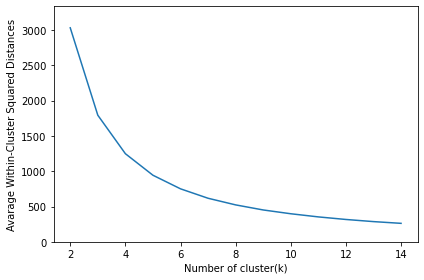

Figure 7-7. The elbow method applied to the stock data


In [18]:
# For the KMeans result, we get this information from the property inertia_. After conversion
# into a pandas data frame, we can use its plot method to create the graph:

inertia = []
for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(top_sp)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(2, 15), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of cluster(k)')
plt.ylabel('Avarage Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)

plt.tight_layout()
plt.show()
print("Figure 7-7. The elbow method applied to the stock data")

In evaluating how many clusters to retain, perhaps the most important test is this:
how likely are the clusters to be replicated on new data? Are the clusters interpretable,
and do they relate to a general characteristic of the data, or do they just reflect a specific
instance? You can assess this, in part, using cross-validation; see “Cross-
Validation” on page 155.
In general, there is no single rule that will reliably guide how many clusters to
produce.

## Hierarchical Clustering

### A Simple Example
For applications involving numeric data, the most importance choice is the dissimilarity
metric. Hierarchical clustering starts by setting each record as its own cluster
and iterates to combine the least dissimilar clusters.

Clustering algorithms will cluster the records (rows) of a data frame. Since we want to
cluster the companies, we need to transpose (t) the data frame and put the stocks
along the rows and the dates along the columns.

The scipy package offers a number of different methods for hierarchical clustering in
the scipy.cluster.hierarchy module. Here we use the linkage function with the
“complete” method:

In [19]:
syms1 = ['AAPL', 'AMZN', 'AXP', 'COP', 'COST', 'CSCO', 'CVX', 'GOOGL', 'HD', 
         'INTC', 'JPM', 'MSFT', 'SLB', 'TGT', 'USB', 'WFC', 'WMT', 'XOM']
df = sp500_px.loc[sp500_px.index >= '2011-01-01', syms1].transpose()

Z = linkage(df, method='complete')
print(Z.shape)

(17, 4)


### The Dendrogram
Hierarchical clustering lends itself to a natural graphical display as a tree, referred to
as a dendrogram. The name comes from the Greek words dendro (tree) and gramma
(drawing).


We can use the dendrogram method to plot the result of the linkage function in
Python:

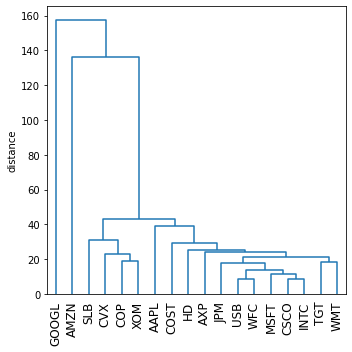

Figure 7-8. A dendrogram of stocks


In [20]:
fig, ax = plt.subplots(figsize=(5, 5))
dendrogram(Z, labels=list(df.index), color_threshold=0)
plt.xticks(rotation=90)
ax.set_ylabel('distance')

plt.tight_layout()
plt.show()
print("Figure 7-8. A dendrogram of stocks")

The result is shown in Figure 7-8 (note that we are now plotting companies that are
similar to one another, not days). The leaves of the tree correspond to the records.
The length of the branch in the tree indicates the degree of dissimilarity between corresponding
clusters. The returns for Google and Amazon are quite dissimilar to one
another and to the returns for the other stocks. The oil stocks (SLB, CVX, XOM,
COP) are in their own cluster, Apple (AAPL) is by itself, and the rest are similar to
one another.

In [21]:
# In Python, you achieve the same with the fcluster method:
memb = fcluster(Z, 4, criterion='maxclust')
memb = pd.Series(memb, index=df.index)
for key, item in memb.groupby(memb):
    print(f"{key} : {','.join(item.index)}")


1 : COP,CVX,SLB,XOM
2 : AAPL,AXP,COST,CSCO,HD,INTC,JPM,MSFT,TGT,USB,WFC,WMT
3 : AMZN
4 : GOOGL


The number of clusters to extract is set to 4, and you can see that Google and Amazon
each belong to their own cluster. The oil stocks all belong to another cluster. The
remaining stocks are in the fourth cluster

### Measures of Dissimilarity

TypeError: object of type 'float' has no len()

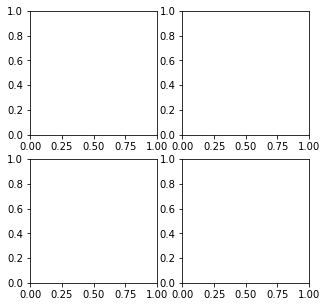

In [58]:
# df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))
# for i, method in enumerate(['single', 'average', 'complete', 'ward']):
#     ax = axes[i // 2, i % 2]
#     Z = linkage(df, method=method)
#     colors = [f'C{c+1}' for c in fcluster(Z, 4, criterion='maxclust')]
#     ax = sns.scatterplot(ax=ax, data=df, x='XOM', y='CVX', hue=colors, style=colors, 
#                         size=0.5,legend=False)
    
#     ax.set_xlim(-3, 3)
#     ax.set_ylim(-3, 3)
#     ax.set_title(method)
    
# plt.tight_layout()
# plt.show()
# # print("")

df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))
for i, method in enumerate(['single', 'average', 'complete', 'ward']):
    ax = axes[i // 2, i % 2]
    Z = linkage(df, method=method)
    colors = [f'C{c+1}' for c in fcluster(Z, 4, criterion='maxclust')]
    ax = sns.scatterplot(x='XOM', y='CVX', hue=colors, style=colors,
                         size=0.5, ax=ax, data=df, legend=False)

    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_title(method)

plt.tight_layout()
plt.show()


## Model based clustering

### Multivariate Normal Distribution
 >Define a colormap that corresponds to the probablility levels

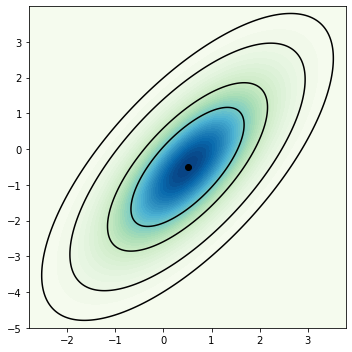

Figure 7-10. Probability contours for a two-dimensional normal distribution


In [64]:
mean = [0.5, -0.5]
cov = [[1, 1], [1, 2]]
probability = [.5, .75, .95, .99]
def problevel(p):
    D = 1 
    return (1 - p) / (2 * math.pi * D)
levels = [probLevel(p) for p in probability]

fig, ax = plt.subplots(figsize=(5, 5))

x, y = np.mgrid[-2.8:3.8:.01, -5:4:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal(mean, cov)

CS = ax.contourf(x, y, rv.pdf(pos), cmap=cm.GnBu, levels=50)
ax.contour(CS, levels=levels, colors=['black'])
ax.plot(*mean, color='black', marker='o')

plt.tight_layout()
plt.show()
print("Figure 7-10. Probability contours for a two-dimensional normal distribution")

### Mixtures of Normals
The key idea behind model-based clustering is that each record is assumed to be distributed
as one of K multivariate normal distributions, where K is the number of clusters. Each distribution has a different mean μ and covariance matrix Σ. 
For
example, if you have two variables, X and Y, then each row Xi, Yi is modeled as having
been sampled from one of K multivariate normal distributions
N μ1, Σ1 ,N μ2, Σ2 , ...,N μK, ΣK .

In [69]:
# scikit-learn has the sklearn.mixture.GaussianMixture class for model-based clustering:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
mclust = GaussianMixture(n_components=2).fit(df)
print(mclust.bic(df))

4589.3203170532615


If you execute this code, you will notice that the computation takes significantly
longer than other procedures. Extracting the cluster assignments using the predict
function, we can visualize the clusters

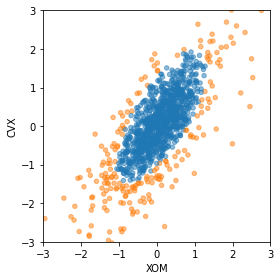

Figure 7-11. Two clusters are obtained for stock return data using mclust


In [70]:
fig, ax = plt.subplots(figsize=(4, 4))
colors = [f'C{c}' for c in mclust.predict(df)]
df.plot.scatter(x='XOM', y='CVX', c=colors, alpha=0.5, ax=ax)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

plt.tight_layout()
plt.show()
print("Figure 7-11. Two clusters are obtained for stock return data using mclust")

In [71]:
# You can extract the parameters to the normal distributions using the summary function:
print("Mean")
print(mclust.means_)
print("Covariances")
print(mclust.covariances_)

Mean
[[ 0.0709161   0.10228006]
 [-0.05074943 -0.21539465]]
Covariances
[[[0.27074158 0.27800893]
  [0.27800893 0.5212865 ]]

 [[0.98668327 0.99350046]
  [0.99350046 1.69695919]]]


The distributions have similar means and correlations, but the second distribution
has much larger variances and covariances. Due to the randomness of the algorithm,
results can vary slightly between different runs.
The clusters from mclust may seem surprising, but in fact, they illustrate the statistical
nature of the method. The goal of model-based clustering is to find the best-fitting
set of multivariate normal distributions. The stock data appears to have a normallooking
shape: see the contours of Figure 7-10. In fact, though, stock returns have a
longer-tailed distribution than a normal distribution. To handle this, mclust fits a
distribution to the bulk of the data but then fits a second distribution with a bigger
variance.

### Selecting the number of clusters



The GaussianMixture implementation on the other hand will not try out various
combinations. As shown here, it is straightforward to run multiple combinations
using Python. This implementation defines BIC as usual. Therefore, the calculated
BIC value will be positive, and we need to minimize it.

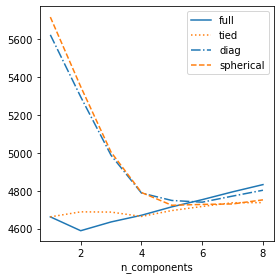

In [73]:
results = []
covariance_types = ['full', 'tied', 'diag', 'spherical']
for n_components in range(1, 9):
    for covariance_type in covariance_types:
#         With the warm_start argument, the calculation will reuse information from the
#         previous fit. This will speed up the convergence of subsequent calculations.
        mclust = GaussianMixture(n_components= n_components, warm_start=True,
                                covariance_type = covariance_type)
        mclust.fit(df)
        results.append({
            'bic': mclust.bic(df),
            'n_components': n_components,
            'covariance_type': covariance_type,
        })
results = pd.DataFrame(results)

colors = ['C0', 'C1', 'C2', 'C3']
styles = ['C0-', 'C1:', 'C0-.', 'C1--']

fig, ax = plt.subplots(figsize=(4, 4))
for i, covariance_type in enumerate(covariance_types):
    subset = results.loc[results.covariance_type == covariance_type, :]
    subset.plot(x='n_components', y='bic', ax=ax, label=covariance_type,
               kind='line', style=styles[i]) # , color=colors[i])
plt.tight_layout()
plt.show()

## Scaling and Categorical Variables

### Scaling the Variables

Variables with very different scale and units need to be normalized appropriately
before you apply a clustering procedure. For example, let’s apply kmeans to a set of
data of loan defaults without normalizing:

In [75]:
loan_data = pd.read_csv(LOAN_DATA_CSV)
loan_data['outcome'] = pd.Categorical(loan_data['outcome'],
                                     categories=['paid off', 'default'],
                                     ordered=True)
defaults = loan_data.loc[loan_data['outcome'] == 'default',]

columns = ['loan_amnt', 'annual_inc', 'revol_bal', 'open_acc',
          'dti', 'revol_util']

df = defaults[columns]
kmeans = KMeans(n_clusters=4, random_state=1).fit(df)
counts = Counter(kmeans.labels_)

centers = pd.DataFrame(kmeans.cluster_centers_, columns=columns)
centers['size'] = [counts[i] for i in range(4)]
print(centers)
                        

      loan_amnt     annual_inc     revol_bal   open_acc        dti  \
0  18275.132345   83354.634595  19635.189254  11.664373  16.774586   
1  21852.701005  165407.730318  38907.295645  12.597152  13.466876   
2  10591.893792   42453.058692  10268.048598   9.583820  17.713563   
3  22570.192308  489783.403846  85161.346154  13.326923   6.907500   

   revol_util   size  
0   62.258588   7543  
1   63.634900   1194  
2   58.111226  13882  
3   59.651923     52  


A common approach to scaling the variables is to convert them to z-scores by
subtracting the mean and dividing by the standard deviation. This is termed
standardization or normalization (see “Standardization (Normalization, z-Scores)” on
page 243 for more discussion about using z-scores):
z = (x − x) / s

In Python, we can use scikit-learn’s StandardScaler. The inverse_transform
method allows converting the cluster centers back to the original scale:

In [76]:
scaler = preprocessing.StandardScaler()
df0 = scaler.fit_transform(df * 1.0)

kmeans = KMeans(n_clusters=4, random_state=1).fit(df0)
counts = Counter(kmeans.labels_)

centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_),
                       columns=columns)

centers['size'] = [counts[i] for i in range(4)]
print(centers)

      loan_amnt     annual_inc     revol_bal   open_acc        dti  \
0  10499.824632   51070.958451  11629.172535   7.511129  15.965747   
1  10315.255666   53468.181307   6032.616033   8.637385  11.255855   
2  25920.260952  116308.326663  32827.641428  12.389941  16.204021   
3  13420.700048   55844.852918  16370.832021  14.334512  24.189881   

   revol_util  size  
0   77.806693  7405  
1   31.000342  5339  
2   66.172004  3701  
3   59.227862  6226  


The cluster sizes are more balanced, and the clusters are not dominated by
annual_inc and revol_bal, revealing more interesting structure in the data. Note
that the centers are rescaled to the original units in the preceding code. If we had left
them unscaled, the resulting values would be in terms of z-scores and would therefore
be less interpretable.

### Dominant Variables

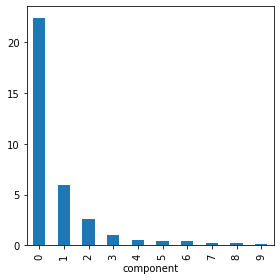

Figure 7-13. A screeplot for a PCA of top stocks from the S&P 500, including GOOGL and AMZN


In [80]:
syms = ['GOOGL', 'AMZN', 'AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM',
       'SLB', 'COP', 'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST']
top_sp1 = sp500_px.loc[sp500_px.index >= '2005-01-01', syms]

sp_pca1 = PCA()
sp_pca1.fit(top_sp1)

explained_variance = pd.DataFrame(sp_pca1.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('component')

plt.tight_layout()
plt.show()
print("Figure 7-13. A screeplot for a PCA of top stocks from the S&P 500, including GOOGL and AMZN")

The screeplot displays the variances for the top principal components. In this case,
the screeplot in Figure 7-13 reveals that the variances of the first and second components
are much larger than the others. This often indicates that one or two variables
dominate the loadings. This is, indeed, the case in this example:

In [79]:
loadings = pd.DataFrame(sp_pca1.components_[0:2, :],
                       columns=top_sp1.columns)
print(loadings.transpose())

              0         1
GOOGL -0.857310  0.477873
AMZN  -0.444728 -0.874149
AAPL  -0.071627 -0.020802
MSFT  -0.036002 -0.006204
CSCO  -0.029205 -0.003045
INTC  -0.026666 -0.006069
CVX   -0.089548 -0.037420
XOM   -0.080336 -0.020511
SLB   -0.110218 -0.030356
COP   -0.057739 -0.024117
JPM   -0.071228 -0.009244
WFC   -0.053228 -0.008597
USB   -0.041670 -0.005952
AXP   -0.078907 -0.024027
WMT   -0.040346 -0.007141
TGT   -0.063659 -0.024662
HD    -0.051412 -0.032922
COST  -0.071403 -0.033826


The first two principal components are almost completely dominated by GOOGL
and AMZN. This is because the stock price movements of GOOGL and AMZN dominate
the variability.

### Categorical Data and Gower's Distance
> Currently not available in any of the standart packages. However work is in progress to add it to scikit-learn. We will update this notebook once it becomes available

In [81]:
x = defaults[['dti', 'payment_inc_ratio', 'home_', 'purpose_']].loc[0:4. :]
print(x)

     dti  payment_inc_ratio home_            purpose_
0   1.00            2.39320  RENT      major_purchase
1   5.55            4.57170   OWN      small_business
2  18.08            9.71600  RENT               other
3  10.08           12.21520  RENT  debt_consolidation
4   7.06            3.90888  RENT               other


```

###############################################################
## Figure 7-13: Categorical data and Gower's distance

x <- loan_data[1:5, c('dti', 'payment_inc_ratio', 'home_', 'purpose_')]
x

daisy(x, metric='gower')

set.seed(301)
df <- loan_data[sample(nrow(loan_data), 250),
                c('dti', 'payment_inc_ratio', 'home_', 'purpose_')]
d = daisy(df, metric='gower')
hcl <- hclust(d)
dnd <- as.dendrogram(hcl)

png(filename=file.path(PSDS_PATH, 'figures', 'psds_0713.png'), width = 4, height=4, units='in', res=300)
par(mar=c(0,5,0,0)+.1)
plot(dnd, leaflab='none', ylab='distance')
dev.off()

dnd_cut <- cut(dnd, h=.5)
df[labels(dnd_cut$lower[[1]]),]


## Problems in clustering with mixed data types
df <- model.matrix(~ -1 + dti + payment_inc_ratio + home_ + pub_rec_zero, data=defaults)
df0 <- scale(df)
km0 <- kmeans(df0, centers=4, nstart=10)
centers0 <- scale(km0$centers, center=FALSE, scale=1/attr(df0, 'scaled:scale'))
round(scale(centers0, center=-attr(df0, 'scaled:center'), scale=FALSE), 2)
```

### Problemns with Clustering Mixed Data

In [82]:
columns = ['dti', 'payment_inc_ratio', 'home_', 'pub_rec_zero']
df = pd.get_dummies(defaults[columns])

scaler = preprocessing.StandardScaler()

df0 = scaler.fit_transform(df * 1.0)
kmeans = KMeans(n_clusters=4, random_state=1).fit(df0)
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_),
                      columns=df.columns)
print(centers)

         dti  payment_inc_ratio  pub_rec_zero  home__MORTGAGE     home__OWN  \
0  16.992128           9.105395  1.000000e+00    9.436896e-15  3.344547e-15   
1  17.456244           8.422914  1.000000e+00    1.000000e+00  1.901257e-15   
2  16.504955           8.064247  9.325873e-15    5.156600e-01  1.526557e-16   
3  17.197993           9.266666  9.179025e-01   -2.331468e-15  1.000000e+00   

     home__RENT  
0  1.000000e+00  
1  1.643130e-14  
2  4.843400e-01  
3 -2.220446e-15  


The top four clusters are essentially proxies for the different levels of the factor variables.
To avoid this behavior, you could scale the binary variables to have a smaller
variance than other variables. Alternatively, for very large data sets, you could apply
clustering to different subsets of data taking on specific categorical values. For example,
you could apply clustering separately to those loans made to someone who has a
mortgage, owns a home outright, or rents.
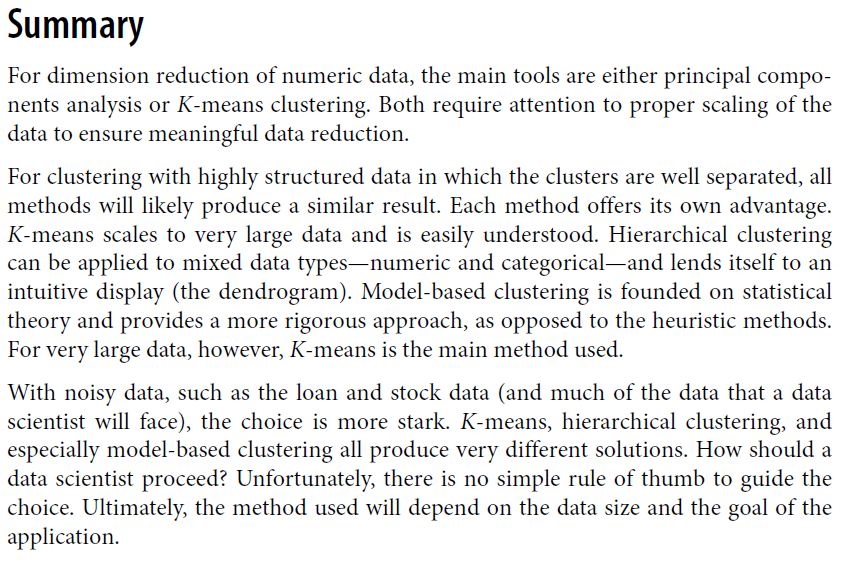